<a href="https://colab.research.google.com/github/KenzioDG/Colab-Projects/blob/main/Bayesian_Email_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

The primary role of email spam predictions is to automatically filter out unwanted or irrelevant emails from your inbox. This ensures that the inbox remains clutter-free and contains only legitimate and important messages. Spam predictions are instrumental in identifying phishing attempts and emails containing malicious attachments or links. By blocking or flagging such emails, email security is enhanced, protecting users from cyber threats.

While the primary goal is to catch spam, there's also a consideration for avoiding false positives (legitimate emails mistakenly classified as spam). Users and organizations need mechanisms to review and rescue emails that might have been wrongly labeled as spam.


## Dataset

In [ ]:
pip install opendatasets

In [ ]:
pip install kaggle

To load this datast from kaggle, first the kaggle account API token json needs to be imported into the session.

The code below creates a .kaggle directory and copies the Kaggle API key (kaggle.json) into it, then downloads a dataset from Kaggle using od.download.
There are three CSV files read into DataFrames (data1, data2, data3) from the downloaded dataset.

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset")

data1 = pd.read_csv('email-spam-dataset/lingSpam.csv')
data2 = pd.read_csv('email-spam-dataset/enronSpamSubset.csv')
data3 = pd.read_csv('email-spam-dataset/completeSpamAssassin.csv')

data1.head()

100%|██████████| 17.0M/17.0M [00:00<00:00, 102MB/s] 

,Unnamed: 0,Body,Label
0,0,Subject: great part-time or summer job !\n \n ...,1
1,1,Subject: auto insurance rates too high ?\n \n ...,1
2,2,Subject: do want the best and economical hunti...,1
3,3,Subject: email 57 million people for $ 99\n \n...,1
4,4,Subject: do n't miss these !\n \n attention ! ...,1


In [ ]:
data2.head()

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


Therea are a few columns here which aren't needed, thus they can be removed altogether.

In [ ]:
data3.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

data2.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [ ]:
data = pd.concat([data1,data2,data3],axis=0)
data.head()

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


## Data cleaning

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18651 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    18650 non-null  object
 1   Label   18651 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


First off, null values need to be removed

In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18650 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    18650 non-null  object
 1   Label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.1+ KB


The below cell performs text cleaning on the email body text.
x_clnd_link removes hyperlinks from the text using a regular expression.


In [ ]:
x = data["Body"]
x_clnd_link = [re.sub(r"http\S+", "", text) for text in x]

print(x_clnd_link[0])

Subject: great part-time or summer job !
 
 * * * * * * * * * * * * * * * we have display boxes with credit applications that we need to place in the small owner-operated stores in your area . here is what you do : 1 . introduce yourself to the store owner or manager . 2 . use our 90 % effective script which tells them how this little display box will save their customers hundreds of dollars , be a drawing card for their business , and make them from $ 5 . 00 to $ 15 . 00 or more for every app sent in . 3 . find a good spot on the counter , place the box there , and say that nothing more need be done , all you need is his name and address so the company can send him the commission checks . your compensaation will be $ 10 for every box you place . by becoming a representative you could also earn a commission of $ 10 for each application that came from that store . that is of course a much more profitable plan , as it will pay you for months or years for a very small effort . call 1-888 

`x_clnd_link = [re.sub(r"http\S+", "", text) for text in x]`: Creates a new list called x_clnd_link by iterating over each element (text) in the x variable (which contains the email body text). For each text element, it uses a regular expression `(re.sub(r"http\S+", "", text))` to remove any URLs (hyperlinks) within the text. The `re.sub()` function replaces any sequence of characters starting with "http" (or "https") and followed by non-whitespace characters with an empty string, effectively removing the URLs.



In [ ]:
pattern = "[^a-zA-Z0-9]"

`[^a-zA-Z0-9]`: This regular expression pattern consists of square brackets `[...]`, which indicate a character class. Inside the character class, you have:

`^`: The caret symbol as the first character inside the square brackets is a negation or "not" operator. It indicates that you want to match any character that is NOT in the following character set.

`a-zA-Z0-9`: This character set includes all lowercase letters from 'a' to 'z', all uppercase letters from 'A' to 'Z', and all digits from '0' to '9'. In essence, it matches any character that is not a letter (either lowercase or uppercase) or a digit.

In [ ]:
# This means replace all the chars that follow the pattern
x_cleaned = [re.sub(pattern," ",text) for text in x_clnd_link]

Lastly, all the characters are made lowercase

In [ ]:
x_lowered = [text.lower() for text in x_cleaned]
print(x_lowered[0])

subject  great part time or summer job                                    we have display boxes with credit applications that we need to place in the small owner operated stores in your area   here is what you do   1   introduce yourself to the store owner or manager   2   use our 90   effective script which tells them how this little display box will save their customers hundreds of dollars   be a drawing card for their business   and make them from   5   00 to   15   00 or more for every app sent in   3   find a good spot on the counter   place the box there   and say that nothing more need be done   all you need is his name and address so the company can send him the commission checks   your compensaation will be   10 for every box you place   by becoming a representative you could also earn a commission of   10 for each application that came from that store   that is of course a much more profitable plan   as it will pay you for months or years for a very small effort   call 1 888 

## Tokenization

In NLP tasks, text data is converted into numerical features that can be used in machine learning algorithms. It transforms unstructured text data into a format that can be processed, analyzed, and used for a wide range of applications in natural language understanding and text mining.

In the below code, the words are splitted into lists

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
x_tokenized = [nltk.word_tokenize(text) for text in x_lowered]

In [ ]:
print(x_tokenized[0])

['subject', 'great', 'part', 'time', 'or', 'summer', 'job', 'we', 'have', 'display', 'boxes', 'with', 'credit', 'applications', 'that', 'we', 'need', 'to', 'place', 'in', 'the', 'small', 'owner', 'operated', 'stores', 'in', 'your', 'area', 'here', 'is', 'what', 'you', 'do', '1', 'introduce', 'yourself', 'to', 'the', 'store', 'owner', 'or', 'manager', '2', 'use', 'our', '90', 'effective', 'script', 'which', 'tells', 'them', 'how', 'this', 'little', 'display', 'box', 'will', 'save', 'their', 'customers', 'hundreds', 'of', 'dollars', 'be', 'a', 'drawing', 'card', 'for', 'their', 'business', 'and', 'make', 'them', 'from', '5', '00', 'to', '15', '00', 'or', 'more', 'for', 'every', 'app', 'sent', 'in', '3', 'find', 'a', 'good', 'spot', 'on', 'the', 'counter', 'place', 'the', 'box', 'there', 'and', 'say', 'that', 'nothing', 'more', 'need', 'be', 'done', 'all', 'you', 'need', 'is', 'his', 'name', 'and', 'address', 'so', 'the', 'company', 'can', 'send', 'him', 'the', 'commission', 'checks', 'yo

WordNetLemmatizer reduces words to their base or dictionary form, without its prefix or suffix. The lemmatization examples for some words are shown and stored the in x_lemmatized.

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
words = ["bats","removed","cheers","good","stopped","went","fired","cleaner","beers"]
for word in words:
    print(lemma.lemmatize(word),end=" ")

bat removed cheer good stopped went fired cleaner beer 

In [ ]:
x_lemmatized = [[lemma.lemmatize(word) for word in text] for text in x_tokenized]

In [ ]:
print(x_lemmatized[0])

['subject', 'great', 'part', 'time', 'or', 'summer', 'job', 'we', 'have', 'display', 'box', 'with', 'credit', 'application', 'that', 'we', 'need', 'to', 'place', 'in', 'the', 'small', 'owner', 'operated', 'store', 'in', 'your', 'area', 'here', 'is', 'what', 'you', 'do', '1', 'introduce', 'yourself', 'to', 'the', 'store', 'owner', 'or', 'manager', '2', 'use', 'our', '90', 'effective', 'script', 'which', 'tell', 'them', 'how', 'this', 'little', 'display', 'box', 'will', 'save', 'their', 'customer', 'hundred', 'of', 'dollar', 'be', 'a', 'drawing', 'card', 'for', 'their', 'business', 'and', 'make', 'them', 'from', '5', '00', 'to', '15', '00', 'or', 'more', 'for', 'every', 'app', 'sent', 'in', '3', 'find', 'a', 'good', 'spot', 'on', 'the', 'counter', 'place', 'the', 'box', 'there', 'and', 'say', 'that', 'nothing', 'more', 'need', 'be', 'done', 'all', 'you', 'need', 'is', 'his', 'name', 'and', 'address', 'so', 'the', 'company', 'can', 'send', 'him', 'the', 'commission', 'check', 'your', 'com

Next, stopwords which exist in this dataset should be removed. Stopwords can greatly increase the dimensionality of text data. Removing them reduces the number of features or tokens in the dataset, making it more manageable and reducing computational complexity. Because they are usually do not have a meaningful contribution in classifying.

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
x_prepared = [[word for word in text if word not in stopwords] for text in x_lemmatized]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(x_prepared[0])

['subject', 'great', 'part', 'time', 'summer', 'job', 'display', 'box', 'credit', 'application', 'need', 'place', 'small', 'owner', 'operated', 'store', 'area', '1', 'introduce', 'store', 'owner', 'manager', '2', 'use', '90', 'effective', 'script', 'tell', 'little', 'display', 'box', 'save', 'customer', 'hundred', 'dollar', 'drawing', 'card', 'business', 'make', '5', '00', '15', '00', 'every', 'app', 'sent', '3', 'find', 'good', 'spot', 'counter', 'place', 'box', 'say', 'nothing', 'need', 'done', 'need', 'name', 'address', 'company', 'send', 'commission', 'check', 'compensaation', '10', 'every', 'box', 'place', 'becoming', 'representative', 'could', 'also', 'earn', 'commission', '10', 'application', 'came', 'store', 'course', 'much', 'profitable', 'plan', 'pay', 'month', 'year', 'small', 'effort', 'call', '1', '888', '703', '5390', 'code', '3', '24', 'hour', 'receive', 'detail', 'removed', 'mailing', 'list', 'type', 'b2998', 'hotmail', 'com', 'area', 'remove', 'subject', 'area', 'new',

# Training

CountVectorizer builds a vocabulary of all unique tokens (words) present in the entire collection of documents. This vocabulary serves as the set of features for the feature matrix. Each unique word in the vocabulary is assigned a unique integer index. It also tokenizes the texts, however that is redundant as manual tokenizing was already done previously.

In [ ]:
vectorizer = CountVectorizer(max_features=20000)
x = vectorizer.fit_transform([" ".join(text) for text in x_prepared]).toarray()

After completing the data preparation process, the dataset is partitioned into training data with an 80% split and validation data with a 20% split. There are two models for training purposes: the first model being a Naive Bayes classifier, and the second model being a Random Forest classifier. In the case of the Random Forest model opted for the 'gini' criterion due to the relatively straightforward nature of the data, which does not necessitate more complex computations for classification. The following section presents the results of the email spam predictions obtained

In [ ]:
x.shape

(18650, 20000)

Splitting data

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,np.asarray(data["Label"]),random_state=42,test_size=0.2)
x_train.shape

(14920, 20000)

### Naive Bayes Model for Prediction

In [ ]:
start_time = time.time()
NB = GaussianNB()
NB.fit(x_train,y_train)
end_time = time.time()

print(round(end_time-start_time,2))

9.89


In [ ]:
print('Accuracy of Naive Bayes : ',NB.score(x_test,y_test))

Accuracy of Naive Bayes :  0.8187667560321715


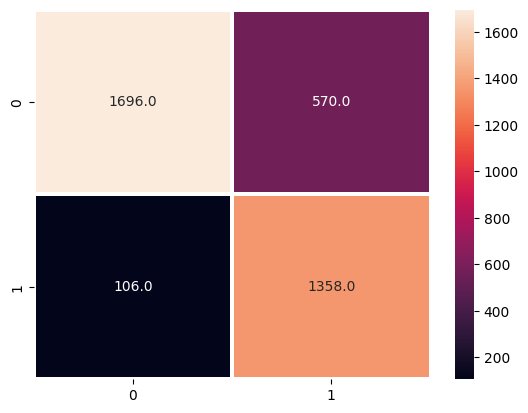

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = NB.predict(x_test)

conf = confusion_matrix(y_pred=y_pred,y_true=y_test)
import seaborn
seaborn.heatmap(conf,annot=True,fmt=".1f",linewidths=1.5)
import matplotlib.pyplot as plt
plt.show()

- True Negative (TN): 1696
- False Positive (FP): 570
- False Negative (FN): 106
- True Positive (TP): 1358

Total correct prediction: 3054 out of 3730

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc

rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
# n_estimators = No. of trees in the forest
# criterion = basis of making the decision tree split, either on gini impurity('gini'), or on infromation gain('entropy')
rfc.fit(x_train,y_train)
y_pred2 = rfc.predict(x_test)
print("Accuracy Score of Random Forest : ", acc(y_pred2,y_test))

Accuracy Score of Random Forest :  0.9638069705093834


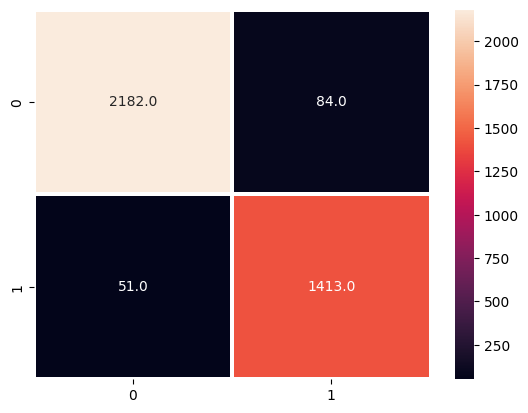

In [ ]:
conf2 = confusion_matrix(y_pred=y_pred2,y_true=y_test)
seaborn.heatmap(conf2,annot=True,fmt=".1f",linewidths=1.5)
plt.show()

- True Negative (TN): 2182
- False Positive (FP): 84
- False Negative (FN): 51
- True Positive (TP): 1413

Total correct prediction: 3595 out of 3730

It was found that the Naive Bayesian model can predict labels effectively; however, the accuracy achieved is lower than that of the Random Forest model. Although that being said, even if the Naive Bayes accuracy lower than Random Forest, there is a possibility that the Random Forest model may have overfitted the predicted data the resultinga accuracy is extremely high in predicting.